# CIS 5450 Recitation 2: Acquiring and Integrating Data

>9/8 (Fri) @ 1:45 PM Nicky Wongchamcharoen and Arnav Jhaveri      
> **\[TBU Zoom Link\]**

(Note that this is the example notebook throughout this week's lecture recordings; we will go through this in more detail through the recitation today and link back towards our data wrangling + XPATH/DOM concepts)

**Our first "deep dive" technical module:**

* Acquiring data from files and remote sources
* Information extraction over HTML content
* A basic "vocabulary" of operators over tables (the relational algebra)
* "Data wrangling" or integration:
  * Cleaning and filtering data, using rules and based operations
  * Linking data across dataframes or relations
  * The need for approximate match and record linking


## Web data
To illustrate the principles, we focus on the question of how old company CEOs and founders are. The question was in part motivated by the following New York Times article:

* Founders of Successful Tech Companies Are Mostly Middle-Aged: https://www.nytimes.com/2019/08/29/business/tech-start-up-founders-nest.html?searchResultPosition=2

**Brief Notes**

Please make a COPY of this first otherwise you won't be able to edit it!
You can go to **File → Make a Copy** to create a copy of the notebook in your own Google Drive.
If you'd like to go through this notebook again from the top - hit the **"Clear All Outputs"** from the **'Edit'** menu.

In [ ]:
python3 --version

In [ ]:
!pip3 install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
# Let's install some libraries useful for processing web data

# Optional, for parallel execution
!pip3 install swifter

!pip3 install Cmake

# For string similarity
!pip3 install py_stringsimjoin==0.3.3 -vvv


# # lxml to parse xml tree
!pip3 install lxml

Using pip 23.2.1 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-build-tracker-o2dzrwaw
Initialized build tracking at /tmp/pip-build-tracker-o2dzrwaw
Created build tracker: /tmp/pip-build-tracker-o2dzrwaw
Entered build tracker: /tmp/pip-build-tracker-o2dzrwaw
Created temporary directory: /tmp/pip-install-api766g_
Created temporary directory: /tmp/pip-ephem-wheel-cache-7w89k5v2
1 location(s) to search for versions of py-stringsimjoin:
* https://pypi.org/simple/py-stringsimjoin/
Fetching project page and analyzing links: https://pypi.org/simple/py-stringsimjoin/
Getting page https://pypi.org/simple/py-stringsimjoin/
Found index url https://pypi.org/simple/
Looking up "https://pypi.org/simple/py-stringsimjoin/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/py-stringsimjoin/ HTTP/1.1" 304 0
F

In [ ]:
# Imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib.request

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import sqlite3

# Can use dataframe.swifter.apply() instead of dataframe.apply()
# to try to parallelize the computation!
import swifter

# Approximate string matching, see
import py_stringsimjoin as ssj
import py_stringmatching as sm

# Data visualization
import matplotlib

# Imports etree from lxml
from lxml import etree

## Acquiring Data

We'll start by loading a (remote) CSV file into a dataframe

In [ ]:
data = urllib.request.urlopen(\
       'https://gist.githubusercontent.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_data_df = pd.read_csv(data)

In [ ]:
# Let's write it to SQL, and read it back

conn = sqlite3.connect('local.db')

company_data_df.to_sql("companies", conn, if_exists="replace", index=False)

pd.read_sql_query('SELECT * FROM companies', conn)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1 750 000,acquired,USA,NY,New York City,New York,1,01/06/2012,2012-06,2012-Q2,2012.0,30/06/2012,30/06/2012
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4 000 000,operating,USA,CA,Los Angeles,Los Angeles,2,None,None,None,NaN,04/06/2010,23/09/2010
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40 000,operating,EST,None,Tallinn,Tallinn,1,26/10/2012,2012-10,2012-Q4,2012.0,09/08/2012,09/08/2012
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1 500 000,operating,GBR,None,London,London,1,01/04/2011,2011-04,2011-Q2,2011.0,01/04/2011,01/04/2011
4,/organization/n-plusn,+n (PlusN),http://plusn.com,|Software|,Software,1 200 000,operating,USA,NY,New York City,New York,2,01/01/2012,2012-01,2012-Q1,2012.0,29/08/2012,04/09/2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47753,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|Android|Education|,Education,320 000,operating,GBR,None,London,London,1,28/01/2013,2013-01,2013-Q1,2013.0,24/03/2014,24/03/2014
47754,/organization/zznode-science-and-technology-co-ltd,ZZNode Science and Technology,http://www.zznode.com,|Enterprise Software|,Enterprise Software,1 587 301,operating,CHN,None,Beijing,Beijing,1,None,None,None,NaN,01/04/2012,01/04/2012
47755,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,97 398,operating,HRV,None,Split,Split,5,13/05/2012,2012-05,2012-Q2,2012.0,01/11/2011,10/09/2014
47756,/organization/a-list-games,[a]list games,http://www.alistgames.com,|Games|,Games,9 300 000,operating,None,None,None,None,1,None,None,None,NaN,21/11/2011,21/11/2011


In [ ]:
# Now let's read an HTML table!

company_ceos_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs')[0]

company_ceos_df

,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31
1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01
3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01
4,Airbus,Guillaume Faury,CEO[5],2012,Succeeded Louis Gallois,2017-11-14
...,...,...,...,...,...,...
169,Williams-Sonoma,Laura J. Alber,President and CEO[155],2010,Replaced W. Howard Lester,2017-11-11
170,WWE,Stephanie McMahon,Chairwoman and Co-CEO (Alongside Nick Khan) [156],2022,"Chairwoman of the executive committee Chairwoman since 2022 CEO since July 22, 2022",2017-11-11
171,Yum! Brands,Greg Creed,CEO[157],2015,Previously CEO for Taco Bell,2017-11-11
172,Zillow Group,Rich Barton,CEO[158],2019,Co-founder and previously was Zillow's CEO for nearly a decade. Succeeded Spencer Rascoff.,2018-12-10


## The Problem Gets Harder... Extracting Structured Fields

We'll start by crawling and scraping data...

In [ ]:
crawl_list = []

for executive in company_ceos_df['Executive']:
  crawl_list.append('https://en.wikipedia.org/wiki/' + executive.replace(' ', '_'))

crawl_list

['https://en.wikipedia.org/wiki/Julie_Sweet',
 'https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla',
 'https://en.wikipedia.org/wiki/Shantanu_Narayen',
 'https://en.wikipedia.org/wiki/Garo_H._Armen',
 'https://en.wikipedia.org/wiki/Guillaume_Faury',
 'https://en.wikipedia.org/wiki/Daniel_Zhang',
 'https://en.wikipedia.org/wiki/Andy_Jassy',
 'https://en.wikipedia.org/wiki/Lisa_Su',
 'https://en.wikipedia.org/wiki/Stephen_Squeri',
 'https://en.wikipedia.org/wiki/Joseph_R._Swedish',
 'https://en.wikipedia.org/wiki/Tim_Cook',
 'https://en.wikipedia.org/wiki/Lakshmi_Niwas_Mittal',
 'https://en.wikipedia.org/wiki/John_Stankey',
 'https://en.wikipedia.org/wiki/Charles_Woodburn',
 'https://en.wikipedia.org/wiki/Tapan_Singhel',
 'https://en.wikipedia.org/wiki/Carlos_Torres_Vila',
 'https://en.wikipedia.org/wiki/Brian_Moynihan',
 'https://en.wikipedia.org/wiki/C.S._Venkatakrishnan',
 'https://en.wikipedia.org/wiki/Warren_Buffett',
 'https://en.wikipedia.org/wiki/Hubert_Joly',
 'https://en.wikipe

In [ ]:
# Use urllib to crawl all pages in crawl_list, and store the response of the page
# in list pages

pages = []

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url
    print('Looking at file %s' % page)
    # Split the url into different parts, and convert the person name into ascii code
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = urllib.request.urlopen((url_ascii))
      #Save page and url for later use.
      pages.append(response)
    except urllib.error.URLError as e:
      print(e.reason)

Looking at file Julie_Sweet
Looking at file Kumar_Mangalam_Birla
Looking at file Shantanu_Narayen
Looking at file Garo_H._Armen
Looking at file Guillaume_Faury
Looking at file Daniel_Zhang
Looking at file Andy_Jassy
Looking at file Lisa_Su
Looking at file Stephen_Squeri
Looking at file Joseph_R._Swedish
Looking at file Tim_Cook
Looking at file Lakshmi_Niwas_Mittal
Looking at file John_Stankey
Looking at file Charles_Woodburn
Looking at file Tapan_Singhel
Looking at file Carlos_Torres_Vila
Looking at file Brian_Moynihan
Looking at file C.S._Venkatakrishnan
Looking at file Warren_Buffett
Looking at file Hubert_Joly
Looking at file Sunil_Bharti_Mittal
Looking at file Stephen_A._Schwarzman
Looking at file Andrew_Mackenzie
Looking at file Oliver_Zipse
Looking at file Dave_Calhoun
Looking at file Rich_Lesser
Looking at file Bob_Dudley
Looking at file Denise_Morrison
Looking at file Mark_Shuttleworth
Looking at file Richard_Fairbank
Looking at file Jim_Umpleby
Looking at file Evan_Greenberg
L

In [ ]:
pages

## Populating the Table with Executives

In [ ]:
# Practice XPath

url = 'https://en.wikipedia.org/wiki/Lisa_Su'
page = url.split("/")[-1] #extract the person name at the end of the url
# Split the url into different parts, and convert the person name into ascii code
url_list = list(urllib.parse.urlsplit(url))
url_list[2] = urllib.parse.quote(url_list[2])
url_ascii = urllib.parse.urlunsplit(url_list)
response = urllib.request.urlopen((url_ascii))
tree = etree.HTML(response.read().decode("utf-8"))  #create a DOM tree of the page
bday = tree.xpath('//table[contains(@class, "vcard")]//tbody/tr/td//span[@class="bday"]/text()')
# bday = tree.xpath('//span[@class="bday"]/text()')
# bday = tree.xpath('//table[@class="infobox biography vcard"]//tbody/tr/td//span[@class="bday"]/text()')

bday

['1969-11-07']

In [ ]:
# Use etree.HTML(...) on the HTML content of each page to get a DOM tree that
# can be processed via XPath to extract the bday information.  Store the CEO name,
# webpage, and the birthdate (born) in exec_df.

# We first check that the HTML content has a table of type vcard,
# and then extract the bday information.  If there is no birthdate, the datetime
# value is NaT (not a time).

exec_df = pd.DataFrame(columns=['name','page','born'])

for page in pages:

    tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
    url = page.geturl()
    bday = tree.xpath('//table[contains(@class, "vcard")]//tbody/tr/td//span[@class="bday"]/text()')
    if (len(bday)>0):
        exec_df = exec_df.append({'name': url[url.rfind('/')+1:], 'page': url,
                   'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')}, ignore_index=True)
    else:
            exec_df = exec_df.append({'name': url[url.rfind('/')+1:], 'page': url
                                      , 'born': None}, ignore_index=True)

exec_df['born'] = pd.to_datetime(exec_df['born'], errors='coerce')

exec_df

,name,page,born
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31
4,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22
...,...,...,...
169,Laura_J._Alber,https://en.wikipedia.org/wiki/Laura_J._Alber,NaT
170,Stephanie_McMahon,https://en.wikipedia.org/wiki/Stephanie_McMahon,1976-09-24
171,Greg_Creed,https://en.wikipedia.org/wiki/Greg_Creed,NaT
172,Rich_Barton,https://en.wikipedia.org/wiki/Rich_Barton,NaT


## Manipulating Tables

Looking at our data to clean via *projection*...

In [ ]:
# Let's take a look at the data.  Here's a way of PROJECTING the exec_df dataframe into
# a smaller table

#### TODO: use double brackets to project the name and born columns ####
exec_df[['name', 'born']]

,name,born
0,Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,1967-06-14
2,Shantanu_Narayen,1963-05-27
3,Garo_H._Armen,1953-01-31
4,Guillaume_Faury,1968-02-22
...,...,...
169,Laura_J._Alber,NaT
170,Stephanie_McMahon,1976-09-24
171,Greg_Creed,NaT
172,Rich_Barton,NaT


In [ ]:
# If I use single brackets, I can extract a single column as a Series.
# Notice anything awry?

for person in exec_df['name']:
    print(person)

Julie_Sweet
Kumar_Mangalam_Birla
Shantanu_Narayen
Garo_H._Armen
Guillaume_Faury
Daniel_Zhang
Andy_Jassy
Lisa_Su
Stephen_Squeri
Joseph_R._Swedish
Tim_Cook
Lakshmi_Niwas_Mittal
John_Stankey
Charles_Woodburn
Tapan_Singhel
Carlos_Torres_Vila
Brian_Moynihan
C.S._Venkatakrishnan
Warren_Buffett
Hubert_Joly
Sunil_Bharti_Mittal
Stephen_A._Schwarzman
Andrew_Mackenzie
Oliver_Zipse
Dave_Calhoun
Rich_Lesser
Bob_Dudley
Denise_Morrison
Mark_Shuttleworth
Richard_Fairbank
Jim_Umpleby
Evan_Greenberg
Chuck_Robbins
Jane_Fraser
James_Quincey
Brian_L._Roberts
Thomas_Gottstein
Ola_K%C3%A4llenius
Michael_Dell
Ed_Bastian
Christian_Sewing
Frank_Appel
Roland_Dickey_Jr.
Edward_D._Breen
G._V._Prasad
Devin_Wenig
Andrew_Wilson
B%C3%B6rje_Ekholm
Darren_Woods
Lisa_S._Jones
Carmine_Di_Sibio
Mark_Zuckerberg
Frederick_W._Smith
Rihanna
Sergio_Marchionne
Abigail_Johnson
James_Michael_Lafferty
James_Hackett
Terry_Gou
Lachlan_Murdoch
Daymond_John
Phebe_Novakovic
H._Lawrence_Culp_Jr.
Mary_T._Barra
Emma_Walmsley
David_M._Solom

In [ ]:
# Let's clean the name by removing underscores...

#### TODO: use the df.apply() function to replace an underscore with a space. ####
exec_df['clean_name'] = exec_df['name'].apply(lambda x: x.replace('_', ' '))
# exec_df['clean_name'] = exec_df.apply(lambda x: x['name'].replace('_', ' '), axis=1)
exec_df['clean_name']

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
169          Laura J. Alber
170       Stephanie McMahon
171              Greg Creed
172             Rich Barton
173               Eric Yuan
Name: clean_name, Length: 174, dtype: object

In [ ]:
# We can do the same via SQL.  For the example we'll save the dataframe first...

exec_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('SELECT name, REPLACE(name, "_", " ") AS clean_name FROM temp_exec', conn)

,name,clean_name
0,Julie_Sweet,Julie Sweet
1,Kumar_Mangalam_Birla,Kumar Mangalam Birla
2,Shantanu_Narayen,Shantanu Narayen
3,Garo_H._Armen,Garo H. Armen
4,Guillaume_Faury,Guillaume Faury
...,...,...
169,Laura_J._Alber,Laura J. Alber
170,Stephanie_McMahon,Stephanie McMahon
171,Greg_Creed,Greg Creed
172,Rich_Barton,Rich Barton


## Selecting a subset of the rows

In [ ]:
# Here's how to select a particular column

exec_df['clean_name']

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
169          Laura J. Alber
170       Stephanie McMahon
171              Greg Creed
172             Rich Barton
173               Eric Yuan
Name: clean_name, Length: 174, dtype: object

In [ ]:
# We can apply a test (predicate) to each column, returning a Series of boolean true/false values

exec_df['clean_name'] == 'Julie Sweet'

0       True
1      False
2      False
3      False
4      False
       ...  
169    False
170    False
171    False
172    False
173    False
Name: clean_name, Length: 174, dtype: bool

In [ ]:
# If we compose these, we'll get only those rows where the boolean condition was True

#### TODO: find the rows in exec_df where clean_name has the value "Julie Sweet". ####
exec_df[exec_df['clean_name'] == 'Julie Sweet']

,name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet


In [ ]:
# And in SQL...

exec_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('SELECT * FROM temp_exec WHERE clean_name="Julie Sweet"', conn)

,index,name,page,born,clean_name
0,0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,None,Julie Sweet


## Putting it Together: Updating Cells by Location

### Joining Data

We start with a simple join between company_ceos_df and exec_df and persist it to the database.  We then check how many companies did not have a match on CEO name.

In [ ]:
#in pandas
pd.merge(left = company_ceos_df[['Executive', 'Company']],
         right = exec_df[['clean_name', 'born']],
         left_on=['Executive'],
         right_on=['clean_name'],
         how='inner')

# ALTERNATIVELY:
# company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']],
#                                                 left_on=['Executive'],
#                                                 right_on=['clean_name'])

,Executive,Company,clean_name,born
0,Julie Sweet,Accenture,Julie Sweet,NaT
1,Kumar Mangalam Birla,Aditya Birla Group,Kumar Mangalam Birla,1967-06-14
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31
4,Guillaume Faury,Airbus,Guillaume Faury,1968-02-22
...,...,...,...,...
166,Laura J. Alber,Williams-Sonoma,Laura J. Alber,NaT
167,Stephanie McMahon,WWE,Stephanie McMahon,1976-09-24
168,Greg Creed,Yum! Brands,Greg Creed,NaT
169,Rich Barton,Zillow Group,Rich Barton,NaT


In [ ]:
#in sql
company_ceos_df.to_sql('company_ceos', conn, if_exists="replace")
exec_df.to_sql('executives', conn, if_exists="replace")

pd.read_sql_query('SELECT Executive, Company, clean_name, born FROM company_ceos c ' +\
                  'JOIN executives e ON c.Executive=e.clean_name', conn)

# ALTERNATIVELY:
# pd.read_sql_query('SELECT Executive, Company, clean_name, born FROM company_ceos ' +\
#                   'JOIN executives ON Executive=clean_name', conn)

###Finding the misses in the join.

Note that the join above resulted in 171 rows.  However, there are more rows in company_ceos_df so some executives in companies_ceos_df are not matched to that in exec_df. We can see which are missed using a left outer join; setting "indicator= True" allows us to see which tuples in company_ceos_df failed to find a match (left_only, e.g. row 37 and 47).

In [ ]:
pd.set_option('display.max_rows', 200)
display(company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']],
                                                left_on=['Executive'],
                                                right_on=['clean_name'], how="left", indicator=True))

,Executive,Company,clean_name,born,_merge
0,Julie Sweet,Accenture,Julie Sweet,NaT,both
1,Kumar Mangalam Birla,Aditya Birla Group,Kumar Mangalam Birla,1967-06-14,both
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-27,both
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31,both
4,Guillaume Faury,Airbus,Guillaume Faury,1968-02-22,both
5,Daniel Zhang,Alibaba,Daniel Zhang,1972-01-11,both
6,Andy Jassy,Amazon,Andy Jassy,1968-01-13,both
7,Lisa Su,Advanced Micro Devices,Lisa Su,1969-11-07,both
8,Stephen Squeri,American Express,Stephen Squeri,NaT,both
9,Joseph R. Swedish,Anthem,Joseph R. Swedish,1951-05-17,both


# Cleaning Data

How do we know our data is good?  We can create rules that trigger when the data fails some particular set of **constraints**.

In [ ]:
# Test with validation rules

replace_char = 'Q'

failed = False
for name in exec_df['clean_name']:
  if not name.replace(' ', replace_char).\
          replace('.', replace_char).\
          replace('\'',replace_char).\
          replace('-',replace_char).isalpha():
    print ("Illegal name %s"%name)
    failed = True

if failed:
  raise AssertionError('Found illegal names!')

Illegal name Ola K%C3%A4llenius
Illegal name B%C3%B6rje Ekholm
Illegal name Michael O%27Leary


AssertionError: ignored

### Working around the Errors

Rather than figuring out how to clean these characters, we'll instead look at doing approximate matching.

Now we'll need to import some similarity matching code, to do approximate match between the original names and those returned by Wikipedia


In [ ]:
# We are going to match the strings approximately, via "n-grams" or "q-grams" (sequences of n or q characters)
# Here it's five-grams

tok = sm.QgramTokenizer(qval=5,return_set=True)
exec_df = exec_df.drop_duplicates()

In [ ]:
# Now let's do a similarity join

# We'll reset the index, so there is a unique index field in the company_ceos_df dataframe
company_ceos_df.reset_index(inplace=True)

# Alternatively:
# company_ceos_df = company_ceos_df.reset_index()

output_pairs = ssj.jaccard_join(company_ceos_df, exec_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35,
                                l_out_attrs=['Executive'], r_out_attrs=['name'])

output_pairs

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,_id,l_index,r_page,l_Executive,r_name,_sim_score
0,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,Julie Sweet,Julie_Sweet,1.000000
1,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,Kumar Mangalam Birla,Kumar_Mangalam_Birla,1.000000
2,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,Shantanu Narayen,Shantanu_Narayen,1.000000
3,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,Garo H. Armen,Garo_H._Armen,1.000000
4,4,4,https://en.wikipedia.org/wiki/Guillaume_Faury,Guillaume Faury,Guillaume_Faury,1.000000
5,5,5,https://en.wikipedia.org/wiki/Daniel_Zhang,Daniel Zhang,Daniel_Zhang,1.000000
6,6,6,https://en.wikipedia.org/wiki/Andy_Jassy,Andy Jassy,Andy_Jassy,1.000000
7,7,7,https://en.wikipedia.org/wiki/Lisa_Su,Lisa Su,Lisa_Su,1.000000
8,8,8,https://en.wikipedia.org/wiki/Stephen_Squeri,Stephen Squeri,Stephen_Squeri,1.000000
9,9,9,https://en.wikipedia.org/wiki/Joseph_R._Swedish,Joseph R. Swedish,Joseph_R._Swedish,1.000000


In [ ]:
print(company_ceos_df.columns)
print(output_pairs.columns)
print(exec_df.columns)

Index(['index', 'Company', 'Executive', 'Title', 'Since', 'Notes', 'Updated'], dtype='object')
Index(['_id', 'l_index', 'r_page', 'l_Executive', 'r_name', '_sim_score'], dtype='object')
Index(['name', 'page', 'born', 'clean_name'], dtype='object')


In [ ]:
# At last! Company info + CEO info, together!

#### TODO: merge everything together! start by merging company_ceos_df with output_pairs using the executive names, ####
#### then merge the result with exec_df using the URL of the page ####.
#### name this as total ####
total = company_ceos_df.merge(output_pairs, left_on=['Executive'], right_on=['l_Executive']).\
  merge(exec_df, left_on=['r_page'], right_on=['page'])
total.head()

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_name,_sim_score,name,page,born,clean_name
0,0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,Julie Sweet,Julie_Sweet,1.0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,Kumar Mangalam Birla,Kumar_Mangalam_Birla,1.0,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14,Kumar Mangalam Birla
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,Shantanu Narayen,Shantanu_Narayen,1.0,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27,Shantanu Narayen
3,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,Garo H. Armen,Garo_H._Armen,1.0,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31,Garo H. Armen
4,4,Airbus,Guillaume Faury,CEO[5],2012,Succeeded Louis Gallois,2017-11-14,4,4,https://en.wikipedia.org/wiki/Guillaume_Faury,Guillaume Faury,Guillaume_Faury,1.0,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22,Guillaume Faury


In [ ]:
# Let's get ready to plot
%matplotlib inline

In [ ]:
# Let's visualize the total dataframe again.
total

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_name,_sim_score,name,page,born,clean_name
0,0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,Julie Sweet,Julie_Sweet,1.000000,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,Kumar Mangalam Birla,Kumar_Mangalam_Birla,1.000000,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14,Kumar Mangalam Birla
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,Shantanu Narayen,Shantanu_Narayen,1.000000,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27,Shantanu Narayen
3,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,Garo H. Armen,Garo_H._Armen,1.000000,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31,Garo H. Armen
4,4,Airbus,Guillaume Faury,CEO[5],2012,Succeeded Louis Gallois,2017-11-14,4,4,https://en.wikipedia.org/wiki/Guillaume_Faury,Guillaume Faury,Guillaume_Faury,1.000000,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22,Guillaume Faury
5,5,Alibaba,Daniel Zhang,CEO[6],2015,Previously with Taobao,2018-10-01,5,5,https://en.wikipedia.org/wiki/Daniel_Zhang,Daniel Zhang,Daniel_Zhang,1.000000,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,1972-01-11,Daniel Zhang
6,6,Amazon,Andy Jassy,CEO and president[7],2021,NaN,NaN,6,6,https://en.wikipedia.org/wiki/Andy_Jassy,Andy Jassy,Andy_Jassy,1.000000,Andy_Jassy,https://en.wikipedia.org/wiki/Andy_Jassy,1968-01-13,Andy Jassy
7,7,Advanced Micro Devices,Lisa Su,CEO and president[8],2014,Formerly with Texas Instruments,2018-10-01,7,7,https://en.wikipedia.org/wiki/Lisa_Su,Lisa Su,Lisa_Su,1.000000,Lisa_Su,https://en.wikipedia.org/wiki/Lisa_Su,1969-11-07,Lisa Su
8,8,American Express,Stephen Squeri,Chairman and CEO[9],2018,Former vice chairman of American Express since 2015,2018-10-01,8,8,https://en.wikipedia.org/wiki/Stephen_Squeri,Stephen Squeri,Stephen_Squeri,1.000000,Stephen_Squeri,https://en.wikipedia.org/wiki/Stephen_Squeri,NaT,Stephen Squeri
9,9,Anthem,Joseph R. Swedish,"Chairman, president and CEO[10]",2013,"Previously with Centura Health and Trinity Health (Livonia, Michigan)",2018-10-01,9,9,https://en.wikipedia.org/wiki/Joseph_R._Swedish,Joseph R. Swedish,Joseph_R._Swedish,1.000000,Joseph_R._Swedish,https://en.wikipedia.org/wiki/Joseph_R._Swedish,1951-05-17,Joseph R. Swedish


# Grouping

The `groupby` command allows us to coalesce data by groups.  In Pandas a Group is a special object with a set of rows.  We can see this with the `get_group` command.

In [ ]:
# first, let us sort the rows based on date of birth.
#### HINT: sort_values() may be helpful ####
total[['born', 'Company', 'Executive']].sort_values(by=['born'], ascending = True)

,born,Company,Executive
70,1928-03-07,Henderson Land Development,Lee Shau Kee
18,1930-08-30,Berkshire Hathaway,Warren Buffett
73,1934-12-14,HP Hood,John A. Kaneb
84,1935-11-01,Koch Industries,Charles G. Koch
68,1937-03-22,GVK Industries,Gunupati Venkata Krishna Reddy
67,1939-12-08,GMA Network,Felipe Gozon
164,1941-06-04,Walgreens Boots Alliance,Stefano Pessina
118,1942-10-21,Qantas,Alan Joyce
52,1944-08-11,FedEx,Frederick W. Smith
79,1944-08-17,J.Crew,Millard Drexler


In [ ]:
# Group we care about
datetime.datetime.strptime('1956-03-13', '%Y-%m-%d')

datetime.datetime(1956, 3, 13, 0, 0)

In [ ]:
# Next group the rows by birthdate, and use the .get_group() function to extract the group with a birthday of '1956-03-13'. ####
#### HINT: Take a look at the strptime() function in the Python datetime module!
#### TODO ####

total.groupby(by='born').get_group(datetime.datetime.strptime('1956-03-13', '%Y-%m-%d'))[['Company','Executive','born']]

,Company,Executive,born
81,JP Morgan Chase,James Dimon,1956-03-13


We can apply computations, such as `count`, to the items in the group.  Values that are empty (NaN) do not count (no pun intended).

In [ ]:
type(total)

In [ ]:
total.groupby(by='born').count()

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,l_Executive,r_name,_sim_score,name,page,clean_name
born,,,,,,,,,,,,,,,,
1928-03-07,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1930-08-30,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1934-12-14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1935-11-01,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1937-03-22,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1939-12-08,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1941-06-04,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1942-10-21,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1944-08-11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# We can do this in SQL too...

total.to_sql('total_info', conn, if_exists='replace', index=False)

# By default, SQL will include the Nan value (called NULL in SQL). If we want to exclude it,
# we need to include WHERE ... IS NOT NULL.

pd.read_sql('SELECT born, COUNT(Company) FROM total_info ' +\
            'WHERE born IS NOT NULL GROUP BY born', conn)

,born,COUNT(Company)
0,1928-03-07 00:00:00,1
1,1930-08-30 00:00:00,1
2,1934-12-14 00:00:00,1
3,1935-11-01 00:00:00,1
4,1937-03-22 00:00:00,1
5,1939-12-08 00:00:00,1
6,1941-06-04 00:00:00,1
7,1942-10-21 00:00:00,1
8,1944-08-11 00:00:00,1
9,1944-08-17 00:00:00,1


In [ ]:
total.columns

Index(['index', 'Company', 'Executive', 'Title', 'Since', 'Notes', 'Updated',
       '_id', 'l_index', 'r_page', 'l_Executive', 'r_name', '_sim_score',
       'name', 'page', 'born', 'clean_name'],
      dtype='object')

In [ ]:
# Let's look at when the CEOs were born

#### TODO: Find the number of CEOs who were born on each day (only including days that are included in the original dataframe)####
#### HINT: .count() may be helpful ####

# Set the result equal to the variable birthdays
birthdays = total.groupby(by='born').count()[['Executive']]
birthdays

,Executive
born,
1928-03-07,1
1930-08-30,1
1934-12-14,1
1935-11-01,1
1937-03-22,1
1939-12-08,1
1941-06-04,1
1942-10-21,1
1944-08-11,1


In [ ]:
# Lets check if any of these are from the same person

exec_counts = total.groupby('clean_name').count()['index'] # groups by name and counts number of instances

repeats = [exec_counts.index[i] for i, c in enumerate(exec_counts) if c > 1] # list of executives with more than 1 entry

# finds birthdays of repeated executives
x = total[total['clean_name'].isin(repeats)]['born']
x = x.drop_duplicates()

total[total['born'].isin(x)][['clean_name', 'born']] # prints name and birthday of repeated executives

,clean_name,born
105,Vasant Narasimhan,1976-08-26
106,Vasant Narasimhan,1976-08-26
107,Laxman Narasimhan,1967-05-15
108,Laxman Narasimhan,1967-05-15


In [ ]:
birthdays.sort_values('Executive', ascending = False)

,Executive
born,
1967-05-15,2
1955-10-01,2
1976-08-26,2
1928-03-07,1
1965-01-19,1
1966-10-17,1
1966-08-12,1
1966-05-25,1
1966-02-08,1


In [ ]:
total[total['born'] == '1955-10-01'][['clean_name', 'born']] # birth date of repeated birthday

# The other 2 birthdays with more than 1 count in the above table are accounted for in the part above (repeated executives)

,clean_name,born
141,Dilip Shanghvi,1955-10-01
157,Joseph C. Papa,1955-10-01


Seems like only two executives on the list share the same birthday - Dilip Sanghvi and Joseph C. Papa!

Are there better ways of grouping/showing the data?
  
We can actually use `resample` over dates, with a parameter, to group.

As an example let us group by decade (10 years, where A is the code for year), and visualize the groups using a bar chart:

<Axes: xlabel='born'>

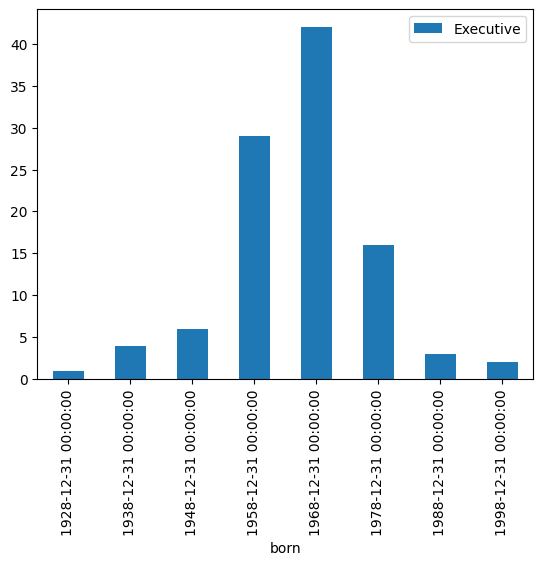

In [ ]:
birthdays.resample('10A').count().plot(kind='bar')

The axes look a little weird.  Can we do something more along the lines of what we expect, i.e., "1920s, 1930s, ..."?

1.   Extract the 'born' column from total and drop all nulls.
2.   For each birthdate, mathematically compute its corresponding decade, and return it as a string with an 's' appended (eg. 1920s, 1930s...). Lambda functions and .apply() function may be helpful here!
3.   Use .reset_index() to revert the 'born' column from index to normal column.
4.   Group by birthdate (now birth-decade!), compute the count of each group, and plot the result as a bar chart!

In [ ]:
total.dtypes

index                   int64
Company                object
Executive              object
Title                  object
Since                  object
Notes                  object
Updated                object
_id                     int64
l_index                 int64
r_page                 object
l_Executive            object
r_name                 object
_sim_score            float64
name                   object
page                   object
born           datetime64[ns]
clean_name             object
dtype: object

<Axes: xlabel='born'>

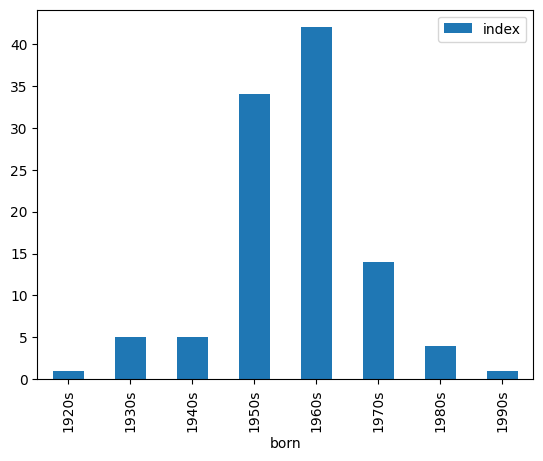

In [ ]:
# TODO: Have a shot at doing this! ####
total['born'].dropna().apply(lambda x: str(int(x.year / 10) * 10) + 's' ).\
  reset_index().groupby(by='born').count().plot(kind='bar')


### ALTERNATE SOLUTION
# Get rid of the nulls!
# bdays = total[['born']].dropna()

# # Compute the decade of each birthday
# bdays = bdays.applymap(lambda bday: str(int(bday.year / 10) * 10) + 's')

# bdays.reset_index().groupby('born').count().plot(kind='bar')

# Bonus Exercise!!!

Can you now link the companies table `company_data_df` so we can figure out the market for each company?

Is there a correlation between the kind of company and the age of the CEO?

In [ ]:
company_data_df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1 750 000,acquired,USA,NY,New York City,New York,1,01/06/2012,2012-06,2012-Q2,2012.0,30/06/2012,30/06/2012
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4 000 000,operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,NaN,04/06/2010,23/09/2010
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40 000,operating,EST,NaN,Tallinn,Tallinn,1,26/10/2012,2012-10,2012-Q4,2012.0,09/08/2012,09/08/2012
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1 500 000,operating,GBR,NaN,London,London,1,01/04/2011,2011-04,2011-Q2,2011.0,01/04/2011,01/04/2011
4,/organization/n-plusn,+n (PlusN),http://plusn.com,|Software|,Software,1 200 000,operating,USA,NY,New York City,New York,2,01/01/2012,2012-01,2012-Q1,2012.0,29/08/2012,04/09/2014


In [ ]:
#### TODO ####
company_ceo_df_final = total[['Company', 'Executive', 'born']].merge(company_data_df[['name', 'market']], left_on='Company', right_on='name', how='inner')
now = pd.Timestamp('now')

print("Before drop: " + str(len(company_ceo_df_final)))
company_ceo_df_final = company_ceo_df_final.dropna() # drops nulls
print("After drop: " + str(len(company_ceo_df_final)))

company_ceo_df_final['age'] = (now - company_ceo_df_final['born']).astype('timedelta64[Y]')
company_ceo_df_final[['market', 'age']].groupby(by='market').mean()

Before drop: 20
After drop: 14


,age
market,
Biotechnology,70.0
Communities,39.0
Consumer Goods,55.0
Design,69.0
E-Commerce,51.0
Hospitality,51.5
Information Technology,62.0
Linux,49.0
Manufacturing,57.0
